In [1]:
import numpy as np
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt

%matplotlib inline

# Calcolo del FID 

Confronto di due distribuzioni con media e covarianza

In [2]:
# calculate frechet inception distance
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

## Esempio con vettori random

Si generano tre vettori di FF in modo da avere un confronto

- molto dissimile tra t1 e t2
- molto simile tra t1 e t3

In [3]:
item1 = np.random.randint(0, 255, size=(2, 32 * 32))
item2 = np.random.randint(0, 255, size=(2, 32 * 32))
item3 = (item1 - 30).clip(0, 255)

FFitem1 = item1 / 255
FFitem2 = item2 / 255
FFitem3 = item3 / 255

fid1 = calculate_fid(FFitem1, FFitem1) 
fid2 = calculate_fid(FFitem1, FFitem2)
fid3 = calculate_fid(FFitem1, FFitem3)

fid1, fid2, fid3

(-0.00011590058413909247, 254.14877577191828, 13.218881622787455)

In [4]:
item1, item3

(array([[ 98, 136, 214, ..., 204, 151,  76],
        [249, 232, 249, ..., 145,  64, 247]]),
 array([[ 68, 106, 184, ..., 174, 121,  46],
        [219, 202, 219, ..., 115,  34, 217]]))

In [5]:
FFitem1

array([[0.38431373, 0.53333333, 0.83921569, ..., 0.8       , 0.59215686,
        0.29803922],
       [0.97647059, 0.90980392, 0.97647059, ..., 0.56862745, 0.25098039,
        0.96862745]])

Proviamo a visualizzare il contenuto dei vettori random come immagine

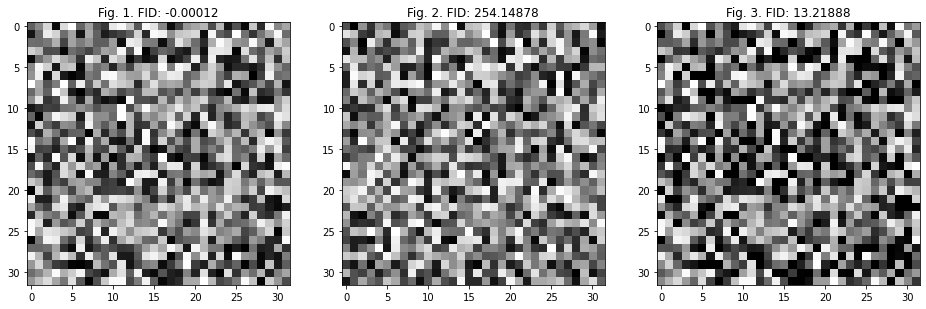

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))

ax1.imshow(item1[0].reshape(32, 32), cmap='gray');
ax1.set_title(f'Fig. 1. FID: {fid1:.5f}')

ax2.imshow(item2[0].reshape(32, 32), cmap='gray');
ax2.set_title(f'Fig. 2. FID: {fid2:.5f}')

ax3.imshow(item3[0].reshape(32, 32), cmap='gray');
ax3.set_title(f'Fig. 3. FID: {fid3:.5f}')

fig.show();

## Vettori non random

Ripetiamo l'esempio precedente costruendo le immagini un una logica

> NB consideriamo valori nella scala dei grigi


In [7]:
example1 = np.zeros((2, 32, 32))
example1[:,:16, :] = 255
example1 = example1.reshape(2, 32*32)

example2 = (example1 - 255) * -1
example3 = np.array(example1)
example3[example3 > 0] = 200
example4 = np.array(example1)
example4[example4 > 0] = 100

FFexample1 = example1 / 255
FFexample2 = example2 / 255
FFexample3 = example3 / 255
FFexample4 = example4 / 255

fid1 = calculate_fid(FFexample1, FFexample1) 
fid2 = calculate_fid(FFexample1, FFexample2)
fid3 = calculate_fid(FFexample1, FFexample3)
fid4 = calculate_fid(FFexample1, FFexample4)

fid1, fid2, fid3, fid4

(0.0, 1024.0, 23.818531334102264, 189.17031910803547)

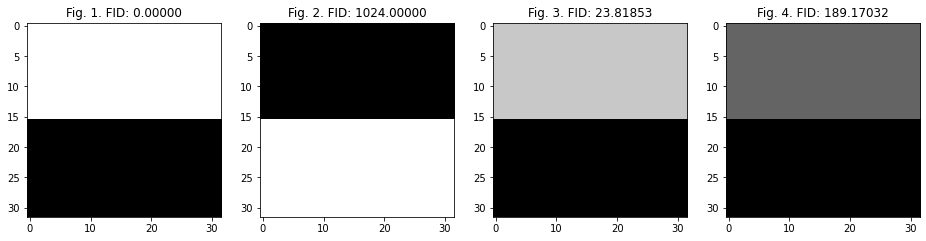

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 8))

ax1.imshow(example1[0].reshape(32, 32), cmap='gray', vmin=0, vmax=255);
ax1.set_title(f'Fig. 1. FID: {fid1:.5f}')

ax2.imshow(example2[0].reshape(32, 32), cmap='gray', vmin=0, vmax=255);
ax2.set_title(f'Fig. 2. FID: {fid2:.5f}')

ax3.imshow(example3[0].reshape(32, 32), cmap='gray', vmin=0, vmax=255);
ax3.set_title(f'Fig. 3. FID: {fid3:.5f}')

ax4.imshow(example4[0].reshape(32, 32), cmap='gray', vmin=0, vmax=255);
ax4.set_title(f'Fig. 4. FID: {fid4:.5f}')

fig.show();

# Un esempio con delle immagini

In [9]:
from PIL import Image
import torch
import torchvision
from torchvision import transforms as T

In [10]:
cat1 = Image.open('cat1.jpg')
cat2 = Image.open('cat2.jpg')
nocat = Image.open('nocat.jpg')

cat1 = cat1.resize((100, 100))
cat2 = cat2.resize((100, 100))
nocat = nocat.resize((100, 100))

tensorMapper = T.ToTensor()

cat1 = tensorMapper(cat1)
cat2 = tensorMapper(cat2)
nocat = tensorMapper(nocat)

## Loading del modello

Carichiamo un modello preaddestrato con cui calcolare le FM

In [11]:
device = 'cuda:0' # oppure 'cpu'

from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=True)
inception_model.to(device)
inception_model = inception_model.eval()

# reset classification layers
inception_model.fc = torch.nn.Identity()


In [12]:
cat1FF = inception_model(cat1.view(1, 3, 100, 100).to(device)).cpu().detach()

cat1FF.shape

/home/pisani/anaconda3/envs/mypy39/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 2048])

Calcoliamo le FM delle immagini in input

In [13]:
cat2FF = inception_model(cat2.view(1, 3, 100, 100).to(device)).cpu().detach()
nocatFF = inception_model(nocat.view(1, 3, 100, 100).to(device)).cpu().detach()

Il FID score si calcola su un batch di immagini (nel paper 50k)

In questo esempio simuliamo un batch di 2 elementi con la stessa immagine.

I risultati non saranno attendibili (media?? varianza??) ma ci danno un'idea di come funziona lo score.

In [14]:
# simulate batch

cat1FF = torch.cat((cat1FF, cat1FF), dim=0)
cat2FF = torch.cat((cat2FF, cat2FF), dim=0)
nocatFF = torch.cat((nocatFF, nocatFF), dim=0)

cat1FF.shape

torch.Size([2, 2048])

In [15]:
fid1 = calculate_fid(cat1FF.numpy(), cat1FF.numpy()) 
fid2 = calculate_fid(cat1FF.numpy(), cat2FF.numpy()) 
fid3 = calculate_fid(cat1FF.numpy(), nocatFF.numpy())

fid1, fid2, fid3

(0.0, 657.1576538085938, 1090.859619140625)

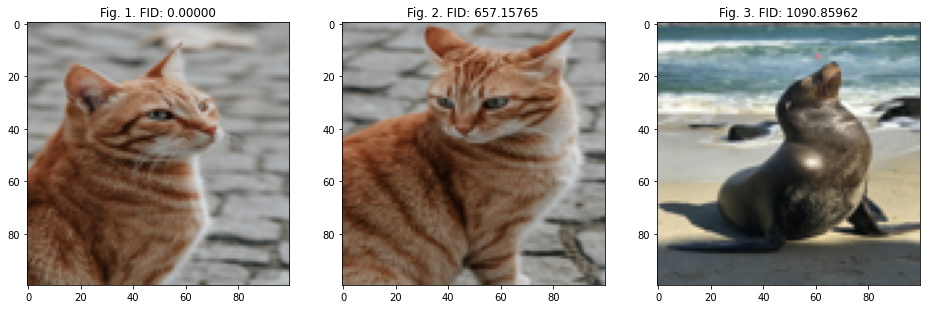

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))

ax1.imshow(cat1.numpy().transpose(1, 2, 0))
ax1.set_title(f'Fig. 1. FID: {fid1:.5f}')

ax2.imshow(cat2.numpy().transpose(1, 2, 0))
ax2.set_title(f'Fig. 2. FID: {fid2:.5f}')

ax3.imshow(nocat.numpy().transpose(1, 2, 0))
ax3.set_title(f'Fig. 3. FID: {fid3:.5f}')

fig.show();

## Esempio con varianti della stessa immagine

Applichiamo un filtro gaussiano con diversi valori di sigma e confrontiamo i valori di FID

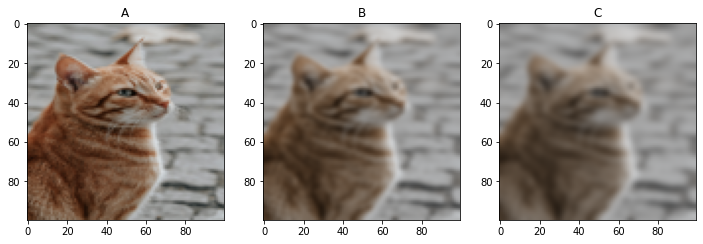

In [22]:
from skimage.filters import gaussian


cat1filteredA = gaussian(cat1, sigma=.1)
cat1filteredB = gaussian(cat1, sigma=1)
cat1filteredC = gaussian(cat1, sigma=1.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

ax1.imshow(cat1filteredA.transpose(1, 2, 0))
ax1.set_title('A')

ax2.imshow(cat1filteredB.transpose(1, 2, 0))
ax2.set_title('B')

ax3.imshow(cat1filteredC.transpose(1, 2, 0))
ax3.set_title('C')

fig.show();

In [23]:
cat1filteredFF_A = inception_model(tensorMapper(cat1filteredA).view(1, 3, 100, 100).to(device)).cpu().detach()
cat1filteredFF_B = inception_model(tensorMapper(cat1filteredB).view(1, 3, 100, 100).to(device)).cpu().detach()
cat1filteredFF_C = inception_model(tensorMapper(cat1filteredC).view(1, 3, 100, 100).to(device)).cpu().detach()

cat1filteredFF_A = torch.cat((cat1filteredFF_A, cat1filteredFF_A), dim=0)
cat1filteredFF_B = torch.cat((cat1filteredFF_B, cat1filteredFF_B), dim=0)
cat1filteredFF_C = torch.cat((cat1filteredFF_C, cat1filteredFF_C), dim=0)

fidAB = calculate_fid(cat1filteredFF_A.numpy(), cat1filteredFF_B.numpy()) 
fidAC = calculate_fid(cat1filteredFF_A.numpy(), cat1filteredFF_C.numpy()) 

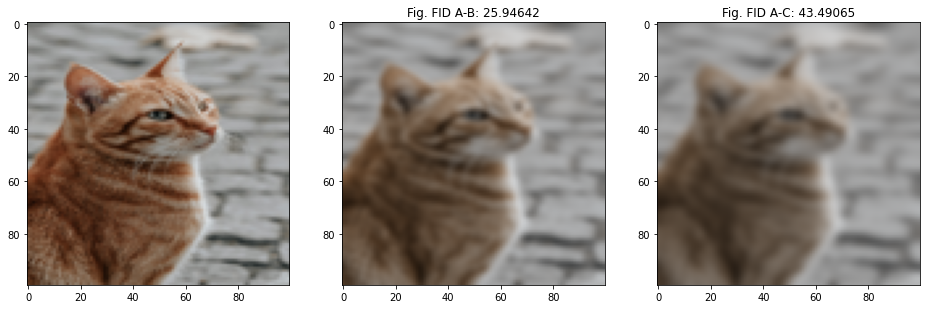

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))

ax1.imshow(cat1filteredA.transpose(1, 2, 0))

ax2.imshow(cat1filteredB.transpose(1, 2, 0))
ax2.set_title(f'Fig. FID A-B: {fidAB:.5f}')

ax3.imshow(cat1filteredC.transpose(1, 2, 0))
ax3.set_title(f'Fig. FID A-C: {fidAC:.5f}')

fig.show();